In [733]:
# !pip uninstall torch -y
# !pip uninstall torchtext -y
# !pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio===0.10.1+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html
# !pip install torchtext==0.9.0

In [734]:
# !python -m spacy download de_core_news_sm

In [735]:
# exit()

# **Preparing the Data**

In [736]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torch.utils.data import DataLoader, random_split
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, Dataset, Example, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

In [737]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [738]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [739]:
class TranslationDataset:
  def __init__(self, filepath):
    self.spacy_en = spacy.load('en_core_web_sm')
    self.spacy_de = spacy.load('de_core_news_sm')
    self.SRC = Field(tokenize=self.tokenize_de, 
                init_token='<sos>', 
                eos_token='<eos>', 
                lower=True, 
                batch_first=True)
    self.TRG = Field(tokenize=self.tokenize_en, 
                init_token='<sos>', 
                eos_token='<eos>', 
                lower=True, 
                batch_first=True)
    self.dataset = TabularDataset(
        path=filepath, format='tsv', skip_header=True,
        fields=[('trg', self.TRG), ('src', self.SRC)]
    )
    
  def __len__(self):
    length = len(self.dataset)
    return length

  def tokenize_de(self, text):
    tokens = [tok.text for tok in self.spacy_de.tokenizer(text)]
    if not tokens:
        return []
    return tokens

  def tokenize_en(self, text):
    tokens = [tok.text for tok in self.spacy_en.tokenizer(text)]
    if not tokens:
        return []
    return tokens
  
  def __getitem__(self, idx):
    en = self.dataset[idx].trg
    de = self.dataset[idx].src
    return de, en

  def splitDataset(self, batch_size=32):
    train_data, valid_data, test_data = self.dataset.split(split_ratio=[0.8, 0.1, 0.1])
    return train_data, valid_data, test_data
  
  def buildVocab(self, data):
    self.SRC.build_vocab(train_data, min_freq = 2)
    self.TRG.build_vocab(train_data, min_freq = 2)
  
  def setIterator(self, train_data, valid_data, test_data, batch_size=32):
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                      batch_size=batch_size,
                                                      device=device,
                                                      sort_key=lambda x: len(x.src),
                                                      sort_within_batch=True,
                                                    )
    return train_iterator, valid_iterator, test_iterator

  
  def getSrcTrg(self):
    return self.SRC, self.TRG


In [740]:
BATCH_SIZE = 128

In [741]:
dataset = TranslationDataset('/content/drive/MyDrive/filtered_dataset2.tsv')

In [742]:
len(dataset)

261

In [743]:
dataset[8]

(['umweltschule'], ['school', 'of', 'the', 'environment'])

In [744]:
train_data, valid_data, test_data = dataset.splitDataset(BATCH_SIZE)

In [745]:
dataset.buildVocab(train_data)

In [746]:
train_iterator, valid_iterator, test_iterator = dataset.setIterator(train_data, valid_data, test_data, BATCH_SIZE)

In [747]:
SRC, TRG = dataset.getSrcTrg()

In [748]:
for batch in train_iterator:
    print(batch)
    break


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 128x11]
	[.src]:[torch.LongTensor of size 128x9]


# **Building the Model**

**Encoder**

In [749]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))  
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [750]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [751]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [752]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

**Decoder**

In [753]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [754]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [755]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


# **Training Model**

In [756]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [757]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [758]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,154,315 trainable parameters


In [759]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [760]:
model.apply(initialize_weights);

In [761]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [762]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [763]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [764]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [765]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [766]:
import random
import math
import time

In [767]:
# Print the size of the SRC and TRG vocabularies
print(len(SRC.vocab), len(TRG.vocab))

# Get a batch from the iterator
batch = next(iter(train_iterator))

# Print the maximum index value in the input tensor
print(torch.max(batch.src).item())

177 203
176


In [768]:
print(torch.max(batch.src).item())
print(enc.tok_embedding.weight.size())

176
torch.Size([177, 256])


**Finding best learning rate**

In [769]:
# def find_best_learning_rate(model, train_loader, start_lr=0.0001, end_lr=0.1, num_iters=50, device='cpu'):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=start_lr)
#     # optimizer = optim.SGD(model.parameters(), lr=start_lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10)
    
#     lr_list = []
#     loss_list = []
    
#     for i in range(num_iters):
#         lr = start_lr + (end_lr - start_lr) * i / (num_iters - 1)
#         optimizer.param_groups[0]['lr'] = lr
#         scheduler.step()
        
#         for batch in train_loader:
#             src = batch.src.to(device)
#             trg = batch.trg.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(src, trg[:,:-1])  # exclude <eos> token from decoder input
#             outputs = outputs[0].contiguous().view(-1, outputs[0].shape[-1])  # reshape for loss computation
#             labels = trg[:,1:].contiguous().view(-1)  # exclude <sos> token from target
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
        
#         loss_list.append(loss.item())
#         lr_list.append(lr)
        
#     # Find the optimal learning rate
#     grad = torch.tensor([loss_list[i+1] - loss_list[i] for i in range(len(loss_list)-1)])
#     idx = torch.argmax(grad).item()
#     best_lr = lr_list[idx]
    
#     return best_lr, lr_list, loss_list

In [770]:
# LEARNING_RATE = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# CLIP = 1
# best_lr = 0
# best_valid_loss = float('inf')  # initialize to a large value

# for epoch in range(10):
#     # Train the model for one epoch
#     train(model, train_iterator, optimizer, criterion, CLIP)
    
#     # Evaluate the model on the validation dataset
#     valid_loss = evaluate(model, valid_iterator, criterion)
    
#     # Update the learning rate based on the validation loss
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_lr = LEARNING_RATE
#         LEARNING_RATE *= 1.1
#     else:
#         LEARNING_RATE /= 2
#         optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# print(f"Best Learning Rate: {best_lr}")
# LEARNING_RATE = best_lr
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [771]:
path = '/content/drive/MyDrive/model.pt'

In [772]:
# best_lr = find_best_learning_rate(model, train_iterator, device=device)

In [773]:
# best_lr

In [774]:
# N_EPOCHS = 100
# CLIP = 1

# best_valid_loss = float('inf')
# trainLoss = []
# validLoss = []

# for epoch in range(N_EPOCHS):
    
#     start_time = time.time()
    
#     train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
#     valid_loss = evaluate(model, valid_iterator, criterion)

#     trainLoss.append(train_loss)
#     validLoss.append(valid_loss)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), path)
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [775]:
N_EPOCHS = 100
CLIP = 1
PATIENCE = 10  # number of epochs to wait before stopping if validation loss doesn't improve
best_valid_loss = float('inf')
trainLoss = []
validLoss = []
no_improvement_count = 0  # number of epochs since validation loss improved

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    trainLoss.append(train_loss)
    validLoss.append(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= PATIENCE:
            print(f'Validation loss hasn\'t improved for {PATIENCE} epochs. Stopping early.')
            break
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 2s
	Train Loss: 5.355 | Train PPL: 211.709
	 Val. Loss: 3.737 |  Val. PPL:  41.990
Epoch: 02 | Time: 0m 4s
	Train Loss: 4.227 | Train PPL:  68.517
	 Val. Loss: 3.198 |  Val. PPL:  24.489
Epoch: 03 | Time: 0m 2s
	Train Loss: 4.185 | Train PPL:  65.692
	 Val. Loss: 3.059 |  Val. PPL:  21.309
Epoch: 04 | Time: 0m 2s
	Train Loss: 4.021 | Train PPL:  55.753
	 Val. Loss: 2.967 |  Val. PPL:  19.436
Epoch: 05 | Time: 0m 2s
	Train Loss: 3.932 | Train PPL:  51.019
	 Val. Loss: 3.045 |  Val. PPL:  21.013
Epoch: 06 | Time: 0m 2s
	Train Loss: 3.885 | Train PPL:  48.645
	 Val. Loss: 2.913 |  Val. PPL:  18.410
Epoch: 07 | Time: 0m 2s
	Train Loss: 3.847 | Train PPL:  46.840
	 Val. Loss: 2.915 |  Val. PPL:  18.445
Epoch: 08 | Time: 0m 3s
	Train Loss: 3.852 | Train PPL:  47.081
	 Val. Loss: 2.924 |  Val. PPL:  18.607
Epoch: 09 | Time: 0m 3s
	Train Loss: 3.791 | Train PPL:  44.312
	 Val. Loss: 2.894 |  Val. PPL:  18.073
Epoch: 10 | Time: 0m 2s
	Train Loss: 3.753 | Train PPL:  42.661


In [776]:
model.load_state_dict(torch.load(path))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.450 | Test PPL:  11.592 |


# **Translating using our model**

In [777]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [778]:
example_idx = 4

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['school', 'of', 'public', 'health']
trg = ['school', 'of', 'public', 'health']


In [779]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['school', 'of', 'school', 'of', '<unk>', '<eos>']


In [780]:
example_idx = 33

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['in', 'den', 'medien']
trg = ['in', 'the', 'media']


In [781]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'in', 'the', 'media', '<eos>']


In [782]:
example_idx = 40

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'yale', 'school', 'of', 'medicine', 'begrüßt', 'während', 'der', 'jährlichen', 'white', 'coat-zeremonie', 'das', 'erste', 'studienjahr', 'zu', 'einem', 'leben', 'in', 'der', 'medizin', '.']
trg = ['the', 'yale', 'school', 'of', 'medicine', 'welcomes', 'first', '-', 'year', 'students', 'to', 'a', 'life', 'in', 'medicine', 'during', 'the', 'annual', 'white', 'coat', 'ceremony', '.']


In [783]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['the', 'the', 'yale', 'the', '<unk>', 'yale', 'the', '<unk>', 'of', 'the', '<unk>', 'the', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-', '<unk>', '-']


In [784]:
len(trainLoss)

43

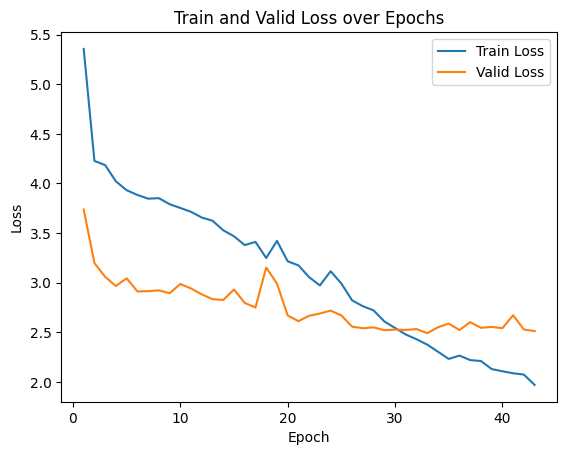

In [785]:
# Plot the train loss and valid loss over epochs
plt.plot(range(1, len(trainLoss)+1), trainLoss, label='Train Loss')
plt.plot(range(1, len(trainLoss)+1), validLoss, label='Valid Loss')

# Set the axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Loss over Epochs')

# Add the legend and show the plot
plt.legend()
plt.show()